# Urban Ecology Research Trend Analysis

Type: NLP + Time Series + Web Data | Domain: Scientific + environmental | Format: Notebook
- Use PubMed or Semantic Scholar API to extract papers on 'urban ecology'.
- Track number of publications per year.
- Perform keyword frequency and topic modeling.
- Map institutions or authors by location 
    .Use author search and Research Organization Registry (ror.org) to map institutions to locations.

In [ ]:
# For future author search
# MODIFY FOR OpenAlex

AUTHOR_URL = 'https://api.semanticscholar.org/graph/v1/author/batch'
AUTHOR_FIELDS = 'affiliations'
AUTHORS_DB_PATH = 'papers.db'
authors_schema = """
    authorId TEXT PRIMARY KEY,
    name TEXT,
    affiliation TEXT
"""

In [168]:
import os
import sys
import time
import math
import pycountry
import requests
import pandas as pd
import numpy as np
import sqlite3
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from itertools import combinations
from collections import Counter

BASE_URL = 'https://api.openalex.org/works'
DELAY = 1  # Small delay between requests
RETRY_DELAY = 5  # seconds before retrying on failure
YEAR_RANGE = '1970-2023' # We start on 1970 as that is considered the decade where urban ecology started gaining interest. We stop on 2023 as it's the last year with complete data
PAPERS_DB_PATH = 'papers.db'

papers_schema = """
    paperId TEXT PRIMARY KEY,
    title TEXT,
    year INTEGER,
    authors TEXT,
    url TEXT,
    search_keyword TEXT,
    firstAuthorCountryIso TEXT,
    firstAuthorId TEXT,
    journal TEXT,
    citationCount INTEGER
"""

query_list = [
    'urban ecology',
    'urban biodiversity',
    'urban ecosystem',
    'urban green spaces',
    'urban wildlife',
    'urban vegetation',
]

In [ ]:
# Run this to clear the .txt progress trackers

for keyword in query_list:
    done_file = f'done_{keyword}.txt'
    page_file = f'page_{keyword}.txt'
    cursor_file = f'cursor_{keyword}.txt'
    
    for file_path in [done_file, page_file, cursor_file]:
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f'✅ Progress tracker "{file_path}" removed.')
  
if os.path.exists(PAPERS_DB_PATH):      
    os.remove(PAPERS_DB_PATH)
    print(f'✅ Output file "{PAPERS_DB_PATH}" removed.')

✅ Progress tracker "cursor_urban ecology.txt" removed.
✅ Progress tracker "cursor_urban biodiversity.txt" removed.
✅ Progress tracker "cursor_urban ecosystem.txt" removed.
✅ Progress tracker "cursor_urban green spaces.txt" removed.
✅ Progress tracker "cursor_urban wildlife.txt" removed.
✅ Progress tracker "cursor_urban vegetation.txt" removed.
✅ Output file "papers.db" removed.


In [34]:
# === Helper functions ===

def save_cursor(keyword, cursor):
    """Save the current cursor for pagination"""
    with open(f'cursor_{keyword}.txt', 'w') as f:
        f.write(cursor)

def load_cursor(keyword):
    """Load the last cursor for pagination"""
    filename = f'cursor_{keyword}.txt'
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            return f.read().strip()
    return None

def mark_done(keyword):
    with open(f'done_{keyword}.txt', 'w') as f:
        f.write('completed')

def is_done(keyword):
    return os.path.exists(f'done_{keyword}.txt')

def delete_cursor(keyword):
    """Clean up cursor tracking file when done"""
    filename = f'cursor_{keyword}.txt'
    if os.path.exists(filename):
        os.remove(filename)

def get_first_author_country(authorships_list):
    """Extract country ISO code prioritizing first author, with fallback to other authors"""
    if not authorships_list:
        return None
    
    first_authorship = authorships_list[0]
    institutions = first_authorship.get('institutions', [])
    
    for institution in institutions:
        country_code = institution.get('country_code')
        if country_code:
            return country_code
    
    for authorship in authorships_list[1:]:
        institutions = authorship.get('institutions', [])
        
        for institution in institutions:
            country_code = institution.get('country_code')
            if country_code:
                return country_code
    
    return None

In [ ]:
# === Database and Dataframe setup ===

def init_table(db_path, table_name, schema_sql):
    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    c.execute(f'CREATE TABLE IF NOT EXISTS {table_name} ({schema_sql})')
    conn.commit()
    conn.close()
    
def save_paper_to_db(paper, keyword):
    conn = sqlite3.connect(PAPERS_DB_PATH)
    c = conn.cursor()

    paper_id = paper.get('id', '').replace('https://openalex.org/', '')
    title = paper.get('title')
    year = paper.get('publication_year')
    citation_count = paper.get('cited_by_count', 0)
    
    primary_location = paper.get('primary_location', {})
    journal = None
    url = None
    if primary_location:
        source = primary_location.get('source', {})
        journal = source.get('display_name') if source else None
        url = primary_location.get('landing_page_url')
    
    authorships = paper.get('authorships', [])
    authors_list = []
    first_author_id = None
    first_author_country = None
    
    for authorship in authorships:
        author = authorship.get('author', {})
        author_name = author.get('display_name')
        if author_name:
            authors_list.append(author_name)
            
        if not first_author_id and author.get('id'):
            first_author_id = author.get('id').replace('https://openalex.org/', '')
            first_author_country = get_first_author_country([authorship])
    
    authors = ', '.join(authors_list)

    try:
        c.execute('SELECT search_keyword FROM papers WHERE paperId = ?', (paper_id,))
        existing = c.fetchone()
        
        if existing:
            existing_keywords = existing[0].split(', ') if existing[0] else []
            if keyword not in existing_keywords:
                existing_keywords.append(keyword)
                updated_keywords = ', '.join(existing_keywords)
                c.execute('UPDATE papers SET search_keyword = ? WHERE paperId = ?', 
                         (updated_keywords, paper_id))
        else:
            c.execute("""
                INSERT INTO papers 
                (paperId, title, year, authors, url, search_keyword, firstAuthorCountryIso, 
                 firstAuthorId, journal, citationCount)
                VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
            """, (paper_id, title, year, authors, url, keyword, first_author_country, 
                  first_author_id, journal, citation_count))
        
        conn.commit()
    except sqlite3.Error as e:
        print(f'❌ DB error for paper {paper_id}: {e}')
    finally:
        conn.close()

In [ ]:
# === Main loop for paper retrieval from OpenAlex ===

init_table(PAPERS_DB_PATH, 'papers', papers_schema)

for keyword in query_list:
    print(f'\n🔍 Processing keyword: "{keyword}"')

    if is_done(keyword):
        print(f'✅ Keyword "{keyword}" already completed. Skipping.')
        continue

    current_cursor = load_cursor(keyword)
    if current_cursor:
        print(f'🔄 Resuming from saved cursor for "{keyword}"')
        cursor = current_cursor
    else:
        print(f'⏳ Starting fresh for keyword "{keyword}"')
        cursor = '*'

    retrieved = 0
    page_count = 0

    while True:
        page_count += 1
        
        params = {
            'search': keyword,
            'filter': f'type:journal-article|book|book-chapter|monograph,publication_year:{YEAR_RANGE}',
            'per_page': 200,
            'cursor': cursor,
            'mailto': 'andre.borja.miranda@gmail.com'
        }

        for attempt in range(2):
            try:
                sys.stdout.flush() # Flush statements to avoid an issue that waas happening where print statements were duplicated after the request
                
                response = requests.get(BASE_URL, params=params, timeout=30)
                response.raise_for_status()
                
                sys.stdout.flush()
                
                data = response.json()
                break
            except requests.exceptions.RequestException as e:
                print(f'❌ Request error on attempt {attempt+1} for "{keyword}" page {page_count}: {e}')
                if attempt == 0:
                    print(f'⏳ Retrying after {RETRY_DELAY} seconds...')
                    time.sleep(RETRY_DELAY)
                else:
                    print('⚠️ Skipping this batch due to repeated failure.')
                    data = None

        if data is None:
            print(f'⚠️ No data retrieved for keyword "{keyword}" page {page_count}, breaking loop.')
            break

        if 'error' in data:
            print(f'❌ API Error for "{keyword}": {data.get("message", "Unknown error")}')
            break

        papers = data.get('results', [])
        if not papers:
            print(f'✅ No more papers available for "{keyword}" (reached end of results)')
            print(f'✅ Completed all available results for "{keyword}" (total: {retrieved} papers across {page_count} pages)')
            delete_cursor(keyword)
            mark_done(keyword)
            break

        retrieved += len(papers)
        print(f'📄 Page {page_count}: {retrieved} papers retrieved for "{keyword}"')

        for paper in papers:
            save_paper_to_db(paper, keyword)

        meta = data.get('meta', {})
        next_cursor = meta.get('next_cursor')
        
        if next_cursor:
            cursor = next_cursor
            save_cursor(keyword, cursor)
            time.sleep(DELAY)
            
        else:
            #Fallback redundancy in case the "if not papers" check fails
            print(f'✅ No more cursor available for "{keyword}" (total: {retrieved} papers across {page_count} pages)')
            delete_cursor(keyword)
            mark_done(keyword)
            break

print('\n🎉 All keywords processed.')


🔍 Processing keyword: "urban ecology"
⏳ Starting fresh for keyword "urban ecology"
📄 Page 1: 200 papers retrieved for "urban ecology"
📄 Page 2: 400 papers retrieved for "urban ecology"
📄 Page 3: 600 papers retrieved for "urban ecology"
📄 Page 4: 800 papers retrieved for "urban ecology"
📄 Page 5: 1000 papers retrieved for "urban ecology"
📄 Page 6: 1200 papers retrieved for "urban ecology"
📄 Page 7: 1400 papers retrieved for "urban ecology"
📄 Page 8: 1600 papers retrieved for "urban ecology"
📄 Page 9: 1800 papers retrieved for "urban ecology"
📄 Page 10: 2000 papers retrieved for "urban ecology"
📄 Page 11: 2200 papers retrieved for "urban ecology"
📄 Page 12: 2400 papers retrieved for "urban ecology"
📄 Page 13: 2600 papers retrieved for "urban ecology"
📄 Page 14: 2800 papers retrieved for "urban ecology"
📄 Page 15: 3000 papers retrieved for "urban ecology"
📄 Page 16: 3200 papers retrieved for "urban ecology"
📄 Page 17: 3400 papers retrieved for "urban ecology"
📄 Page 18: 3600 papers retri

In [69]:
with sqlite3.connect(PAPERS_DB_PATH) as conn:
    df_raw = pd.read_sql_query("""
    SELECT year, search_keyword
    FROM papers
    WHERE search_keyword IS NOT NULL AND search_keyword != ''
    """, conn)

rows = []
for _, row in df_raw.iterrows():
    keywords = [k.strip() for k in row['search_keyword'].split(',')]
    for keyword in keywords:
        if keyword:
            rows.append({'year': row['year'], 'search_keyword': keyword})

df_expanded = pd.DataFrame(rows)
df_keywords = df_expanded.groupby(['year', 'search_keyword']).size().reset_index(name='paper_count')

df_totals = df_expanded.groupby('year').size().reset_index(name='paper_count')
df_totals['search_keyword'] = 'total'

df_keywords = df_keywords.sort_values('year')
df_keywords.head()

,year,search_keyword,paper_count
0,1970,urban biodiversity,1
1,1970,urban ecology,7
2,1970,urban ecosystem,1
3,1970,urban green spaces,10
4,1970,urban vegetation,14


In [ ]:
color_map = {
    'urban ecology': '#6B9BD2',
    'urban biodiversity': '#E6A366',
    'urban green spaces': '#7FB069',
    'urban wildlife': '#D67B7B',
    'urban vegetation': '#B19CD9',
    'urban ecosystem': '#E6A8D0',
    'total': '#FFD700'
}

fig = px.line(
    df_keywords,
    x='year',
    y='paper_count',
    color='search_keyword',
    color_discrete_map=color_map,
    title='Research Papers Published by Year',
    markers=True,
)

fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Number of Papers',
    legend_title='Keyword',
    font=dict(size=12),
    width=1000,
    height=600,
    template='plotly_dark',
    xaxis=dict(showgrid=True,
               dtick=5,
               tickangle=45),
    yaxis=dict(showgrid=True),
)

fig.show()


Totals graph:

In [71]:
fig = px.line(
    df_totals,
    x='year',
    y='paper_count',
    color='search_keyword',
    color_discrete_map=color_map,
    title='Research Papers Published by Year',
    markers=True,
)

fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Number of Papers',
    legend_title='Keyword',
    font=dict(size=12),
    width=1000,
    height=600,
    template='plotly_dark',
    xaxis=dict(showgrid=True,
               dtick=5,
               tickangle=45),
    yaxis=dict(showgrid=True),
)

fig.show()

In [72]:
df_keyword_pivot = df_keywords.pivot(index='year', columns='search_keyword', values='paper_count')
df_rate = df_keyword_pivot.pct_change(fill_method=None)
df_rate.fillna(0, inplace=True)
df_rate.reset_index(inplace=True)

# Regression Analysis on All Papers Published

We'll start with a standard linear regression analysis, then later do a log transform to fit our data to an exponentail growth and see what fits better. The results may change depending on our dataset (year range we choose to obtain our paper data) 

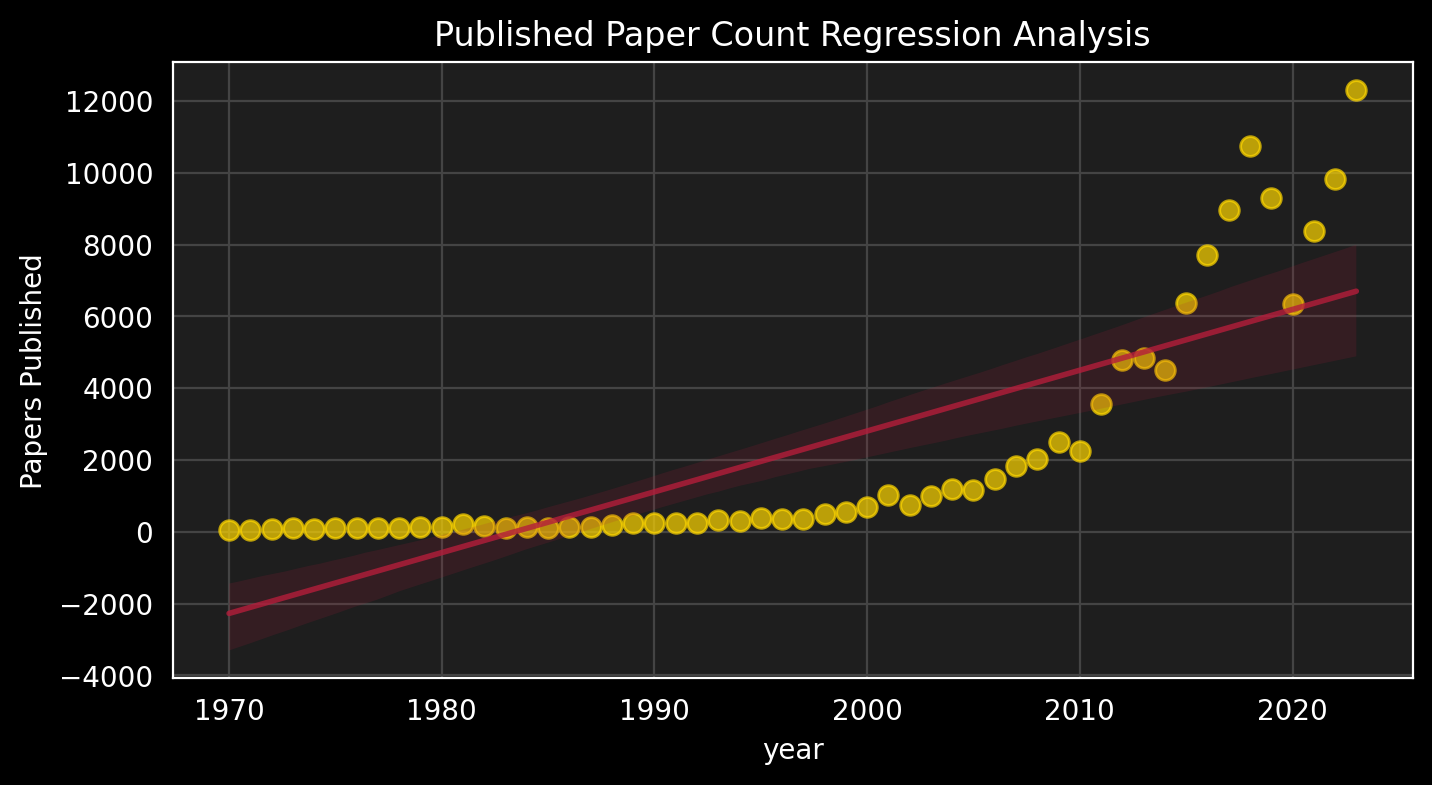

In [ ]:
plt.style.use('dark_background')
plt.figure(figsize=(8,4), dpi=200)

with sns.axes_style('darkgrid', rc={
    'axes.facecolor': '#1e1e1e',
    'figure.facecolor': '#121212',
    'grid.color': '#444444',
    'text.color': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'axes.labelcolor': 'white',
    'axes.edgecolor': 'white',
}):
    with np.errstate(divide='ignore', over='ignore', invalid='ignore'):
        sns.regplot(
                data=df_totals,
                x='year',
                y='paper_count',
                scatter_kws={
                    'marker': 'o',
                    's': 50,
                    'alpha': 0.7,
                    'color': '#FFD700'
                    },
                line_kws={
                    'linewidth': 2,
                    'alpha': 0.8,
                    'color': '#B41D3B'
                    },
            )

plt.title('Published Paper Count Regression Analysis')
plt.ylabel('Papers Published')
    
plt.show()


In [76]:
regression = LinearRegression()
X = pd.DataFrame(df_totals, columns=['year'])
y = pd.DataFrame(df_totals, columns=['paper_count'])
regression.fit(X, y)
print(f'R² Score: {round(regression.score(X, y),3)}')
print(f'Coefficient {round(regression.coef_[0][0],2)}')

R² Score: 0.644
Coefficient 169.32


The linear model shows a poor fit. Below I'll perform the log transform to see if an exponential growth model fits better my data.

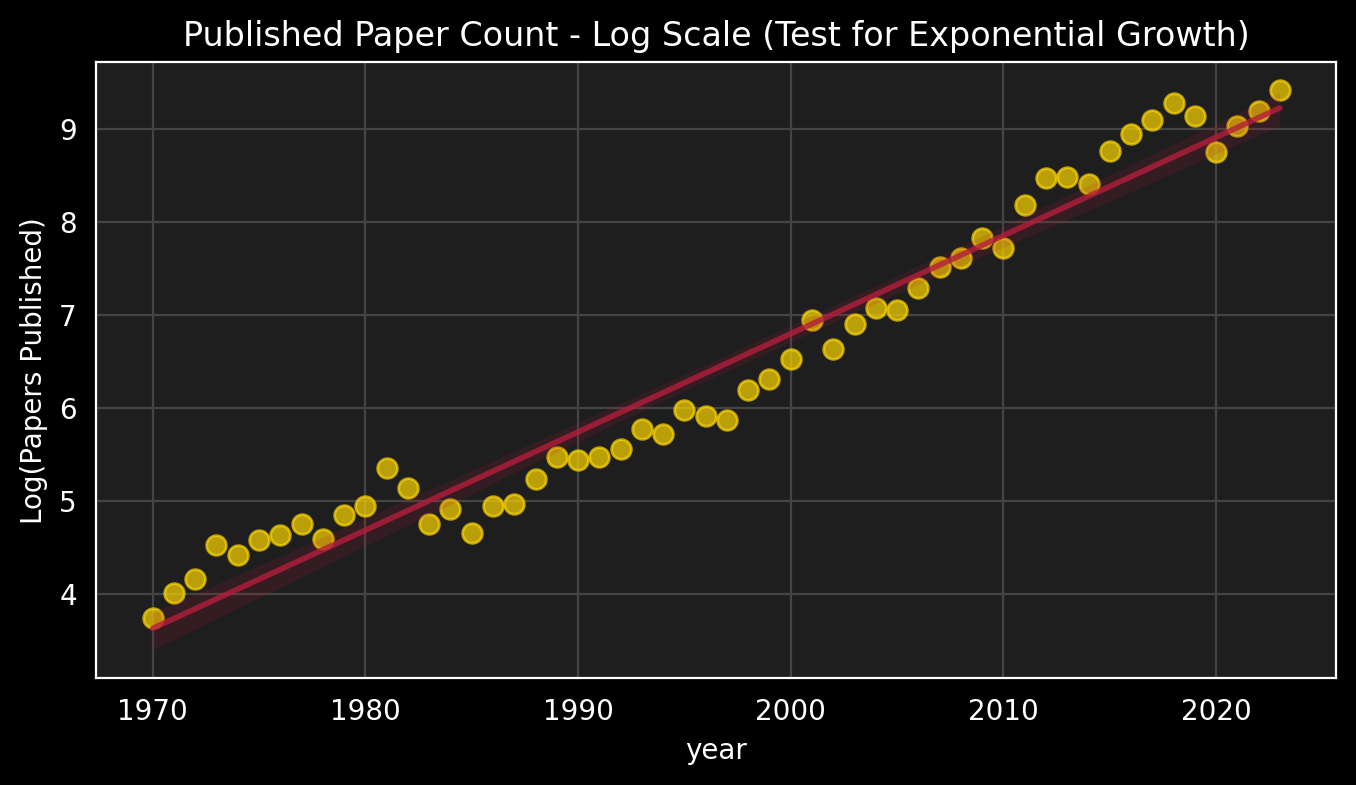

In [ ]:
df_log = df_totals.copy()
df_log['paper_count_log'] = np.log(df_log['paper_count'] + 1)

plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style('darkgrid', rc={
    'axes.facecolor': '#1e1e1e',
    'figure.facecolor': '#121212',
    'grid.color': '#444444',
    'text.color': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'axes.labelcolor': 'white',
    'axes.edgecolor': 'white',
}):
    with np.errstate(divide='ignore', over='ignore', invalid='ignore'):        
        sns.regplot(
                data=df_log,
                x='year',
                y='paper_count_log',
                scatter_kws={
                    'marker': 'o',
                    's': 50,
                    'alpha': 0.7,
                    'color': '#FFD700'
                    },
                line_kws={
                    'linewidth': 2,
                    'alpha': 0.8,
                    'color': '#B41D3B'
                    },
            )

plt.title('Published Paper Count - Log Scale (Test for Exponential Growth)')
plt.ylabel('Log(Papers Published)')
plt.show()


In [78]:
y_log = np.log(y + 1)
regression.fit(X, y_log)
print(f'R² Score: {round(regression.score(X, y_log),3)}')
print(f'Coefficient {round(regression.coef_[0][0],2)}')
growth_rate = (np.exp(0.09) - 1) * 100
print(f'Growth rate: {growth_rate:.2f}% per year')

R² Score: 0.96
Coefficient 0.11
Growth rate: 9.42% per year


We see a great fit in this case, indicating the growth is exponential. Although, a plateau at some point is likely due to real world limits regarding to scientific research and production. Infinite growth is unrealistic.

Now let's analyze the data per keyword, and go a little deeper into the data.

# Per Keyword Analysis

We'll do the same as above, starting with the linear regression analysis, then moving the to the exponential growth analysis (log transform).

COMPREHENSIVE GROWTH ANALYSIS

MODEL COMPARISON RESULTS:
------------------------------------------------------------
              keyword  r_squared_linear  r_squared_log   better_fit  \
2     urban ecosystem          0.615529       0.952564  Exponential   
3  urban green spaces          0.615049       0.946375  Exponential   
1       urban ecology          0.646892       0.947195  Exponential   
0  urban biodiversity          0.674296       0.939802  Exponential   
4    urban vegetation          0.693672       0.946765  Exponential   
5      urban wildlife          0.719227       0.961730  Exponential   

   annual_growth_rate_percent  r_squared_difference  
2                   12.294559              0.337035  
3                   12.061090              0.331326  
1                   10.617228              0.300303  
0                   17.977592              0.265506  
4                    8.853252              0.253093  
5                    8.589296              0.242503  


LOGA

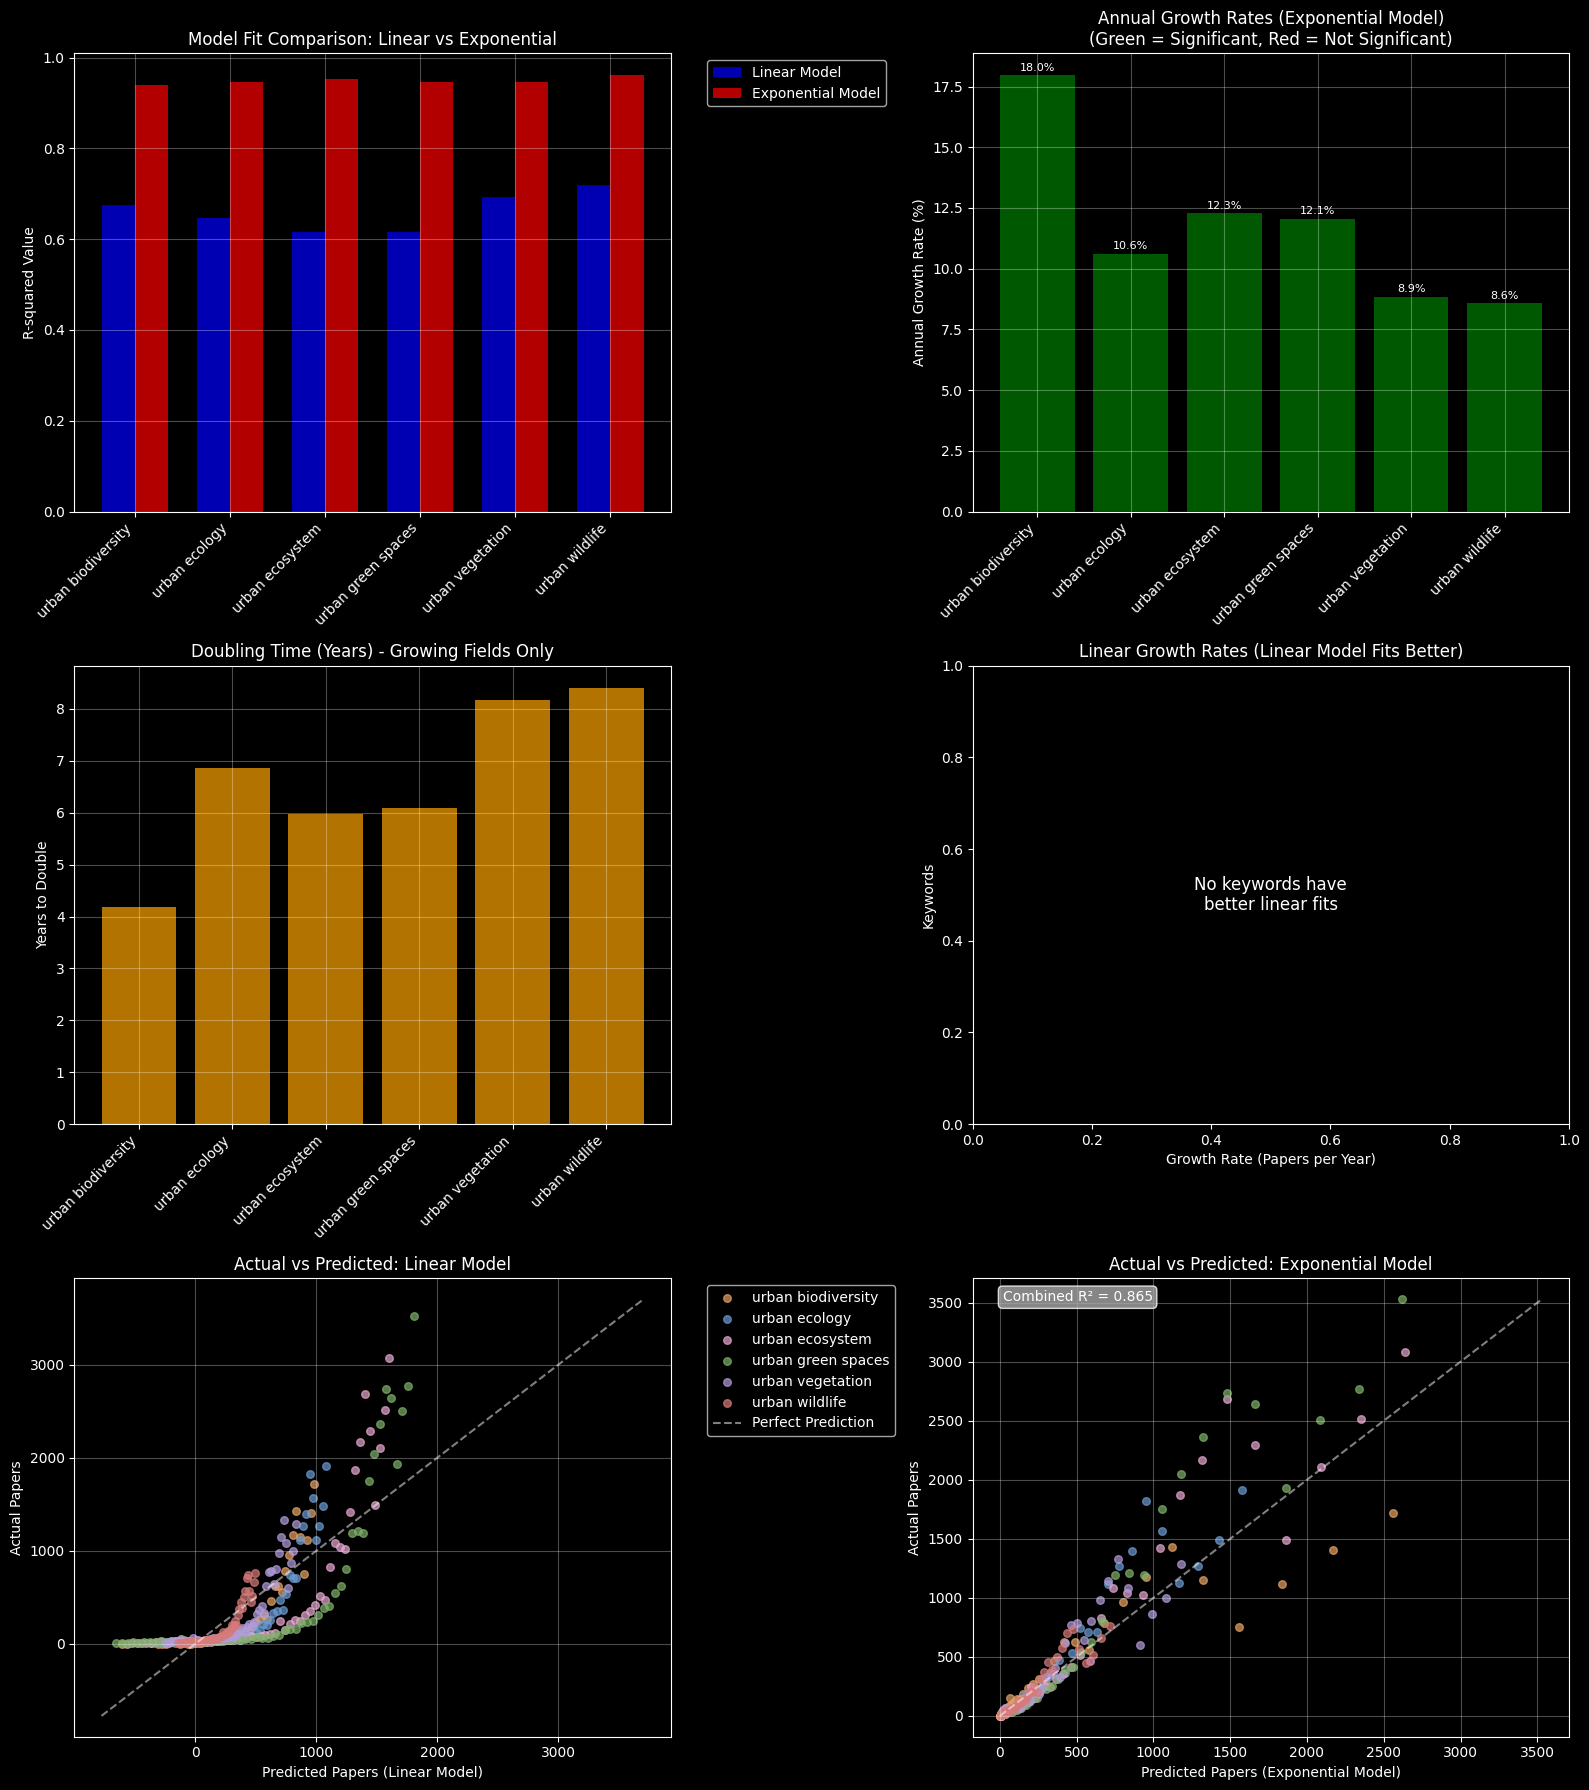


KEY INSIGHTS - GROWTH PATTERN ANALYSIS:
Fastest linear growth: urban green spaces (46.35 papers/year)
Fastest exponential growth: urban biodiversity (18.0% per year)
  - Doubling time: 4.2 years
Fields better explained by exponential growth: 6/6 (100.0%)
Significant linear trends: 6/6
Significant exponential trends: 6/6
Biggest improvement with exponential model: urban ecosystem (ΔR² = +0.337)


In [149]:
def linear_trend_analysis(df_keywords):
    """
    Perform linear regression analysis for each keyword
    Returns comprehensive trend statistics
    """
    results = []
    
    for keyword in df_keywords['search_keyword'].unique():
        keyword_data = df_keywords[df_keywords['search_keyword'] == keyword].sort_values('year')
        years = keyword_data['year'].values
        counts = keyword_data['paper_count'].values
        
        slope, intercept, r_value, p_value, std_err = linregress(years, counts)
        
        r_squared = r_value**2
        
        n = len(years)
        t_val = stats.t.ppf(0.975, n-2)
        slope_ci_lower = slope - t_val * std_err
        slope_ci_upper = slope + t_val * std_err
        
        if p_value < 0.05:
            if slope > 0:
                trend_interpretation = 'Significantly increasing'
            else:
                trend_interpretation = 'Significantly decreasing'
        else:
            trend_interpretation = 'No significant trend'
        
        total_papers = counts.sum()
        avg_papers_per_year = counts.mean()
        
        results.append({
            'keyword': keyword,
            'slope_papers_per_year': slope,
            'intercept': intercept,
            'r_squared': r_squared,
            'p_value': p_value,
            'std_error': std_err,
            'slope_ci_lower': slope_ci_lower,
            'slope_ci_upper': slope_ci_upper,
            'trend_interpretation': trend_interpretation,
            'total_papers': total_papers,
            'avg_papers_per_year': avg_papers_per_year,
            'significant_trend': p_value < 0.05,
            'years_analyzed': n
        })
    
    return pd.DataFrame(results)

def log_trend_analysis(df_keywords, min_papers=1):
    """
    Perform logarithmic regression analysis for each keyword to test exponential growth
    Uses log(paper_count + 1) to handle zero values
    Returns comprehensive trend statistics for exponential growth patterns
    """
    results = []
    
    for keyword in df_keywords['search_keyword'].unique():
        keyword_data = df_keywords[df_keywords['search_keyword'] == keyword].sort_values('year')
        years = keyword_data['year'].values
        counts = keyword_data['paper_count'].values
        
        # Filter out years with very low counts if specified
        if min_papers > 0:
            valid_mask = counts >= min_papers
            if valid_mask.sum() < 3:  # Need at least 3 points for regression
                continue
            years = years[valid_mask]
            counts = counts[valid_mask]
        
        # Log transform: log(count + 1) to handle zeros
        log_counts = np.log(counts + 1)
        
        # Skip if we don't have enough valid data points
        if len(years) < 3:
            continue
            
        slope, intercept, r_value, p_value, std_err = linregress(years, log_counts)
        
        r_squared = r_value**2
        
        n = len(years)
        t_val = stats.t.ppf(0.975, n-2)
        slope_ci_lower = slope - t_val * std_err
        slope_ci_upper = slope + t_val * std_err
        
        # Calculate annual growth rate percentage
        # If log(y) = slope*x + intercept, then y = exp(intercept) * exp(slope)^x
        # Annual growth rate = (exp(slope) - 1) * 100
        annual_growth_rate = (np.exp(slope) - 1) * 100
        
        if p_value < 0.05:
            if slope > 0:
                trend_interpretation = 'Significantly increasing (exponential)'
            else:
                trend_interpretation = 'Significantly decreasing (exponential)'
        else:
            trend_interpretation = 'No significant exponential trend'
        
        total_papers = counts.sum()
        avg_papers_per_year = counts.mean()
        
        # Calculate doubling time (only meaningful for positive growth)
        doubling_time = np.log(2) / slope if slope > 0 else np.inf
        
        results.append({
            'keyword': keyword,
            'log_slope': slope,
            'log_intercept': intercept,
            'r_squared': r_squared,
            'p_value': p_value,
            'std_error': std_err,
            'slope_ci_lower': slope_ci_lower,
            'slope_ci_upper': slope_ci_upper,
            'annual_growth_rate_percent': annual_growth_rate,
            'doubling_time_years': doubling_time,
            'trend_interpretation': trend_interpretation,
            'total_papers': total_papers,
            'avg_papers_per_year': avg_papers_per_year,
            'significant_trend': p_value < 0.05,
            'years_analyzed': n
        })
    
    return pd.DataFrame(results)

def compare_linear_vs_exponential(df_keywords, min_papers=1):
    """
    Compare linear vs exponential growth models for each keyword
    Returns comparison results
    """
    linear_results = linear_trend_analysis(df_keywords)
    log_results = log_trend_analysis(df_keywords, min_papers)
    
    # Merge results for comparison
    comparison = pd.merge(linear_results[['keyword', 'r_squared', 'p_value', 'significant_trend']], 
                         log_results[['keyword', 'r_squared', 'p_value', 'significant_trend', 'annual_growth_rate_percent', 'doubling_time_years']], 
                         on='keyword', suffixes=('_linear', '_log'))
    
    # Determine better fit
    comparison['better_fit'] = np.where(comparison['r_squared_log'] > comparison['r_squared_linear'], 
                                       'Exponential', 'Linear')
    comparison['r_squared_difference'] = comparison['r_squared_log'] - comparison['r_squared_linear']
    
    return comparison, linear_results, log_results


print('COMPREHENSIVE GROWTH ANALYSIS')
print('=' * 80)


df_keywords = df_keywords
comparison, linear_results, log_results = compare_linear_vs_exponential(df_keywords, min_papers=1)

print('\nMODEL COMPARISON RESULTS:')
print('-' * 60)
display_cols = ['keyword', 'r_squared_linear', 'r_squared_log', 'better_fit', 
                'annual_growth_rate_percent', 'r_squared_difference']
print(comparison[display_cols].sort_values('r_squared_difference', ascending=False))

print('\n\nLOGARITHMIC REGRESSION RESULTS (Testing Exponential Growth):')
print('-' * 80)
log_display_cols = ['keyword', 'annual_growth_rate_percent', 'doubling_time_years', 
                   'r_squared', 'p_value', 'trend_interpretation']
print(log_results[log_display_cols].sort_values('annual_growth_rate_percent', ascending=False))

fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# 1. R-squared comparison
ax1 = axes[0, 0]
x_pos = np.arange(len(comparison))
width = 0.35
ax1.bar(x_pos - width/2, comparison['r_squared_linear'], width, label='Linear Model', alpha=0.7, color='blue')
ax1.bar(x_pos + width/2, comparison['r_squared_log'], width, label='Exponential Model', alpha=0.7, color='red')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(comparison['keyword'], rotation=45, ha='right')
ax1.set_ylabel('R-squared Value')
ax1.set_title('Model Fit Comparison: Linear vs Exponential')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Annual growth rates from exponential model
ax2 = axes[0, 1]
growth_rates = log_results['annual_growth_rate_percent']
colors = ['green' if sig else 'red' for sig in log_results['significant_trend']]
bars = ax2.bar(range(len(log_results)), growth_rates, color=colors, alpha=0.7)
ax2.set_xticks(range(len(log_results)))
ax2.set_xticklabels(log_results['keyword'], rotation=45, ha='right')
ax2.set_ylabel('Annual Growth Rate (%)')
ax2.set_title('Annual Growth Rates (Exponential Model)\n(Green = Significant, Red = Not Significant)')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.grid(True, alpha=0.3)

for bar, rate in zip(bars, growth_rates):
    if not np.isnan(rate) and abs(rate) < 1000:
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                f'{rate:.1f}%', ha='center', va='bottom', fontsize=8)

# 3. Doubling times (only for positive growth)
ax3 = axes[1, 0]
finite_doubling = log_results[log_results['doubling_time_years'] != np.inf]
if len(finite_doubling) > 0:
    ax3.bar(range(len(finite_doubling)), finite_doubling['doubling_time_years'], alpha=0.7, color='orange')
    ax3.set_xticks(range(len(finite_doubling)))
    ax3.set_xticklabels(finite_doubling['keyword'], rotation=45, ha='right')
    ax3.set_ylabel('Years to Double')
    ax3.set_title('Doubling Time (Years) - Growing Fields Only')
    ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'No fields with\npositive exponential growth', 
            ha='center', va='center', transform=ax3.transAxes, fontsize=12)
    ax3.set_title('Doubling Time (Years)')

# 4. Linear trend slopes with confidence intervals (conditional on better fit)
ax4 = axes[1, 1]

linear_better_mask = comparison['better_fit'] == 'Linear'
if linear_better_mask.any():
    linear_better_keywords = comparison[linear_better_mask]['keyword'].tolist()
    linear_subset = linear_results[linear_results['keyword'].isin(linear_better_keywords)]
    
    colors = ['green' if sig else 'red' for sig in linear_subset['significant_trend']]
    keywords = linear_subset['keyword']
    slopes = linear_subset['slope_papers_per_year']
    ci_lower = linear_subset['slope_ci_lower']
    ci_upper = linear_subset['slope_ci_upper']
    
    y_pos = np.arange(len(keywords))
    ax4.barh(y_pos, slopes, color=colors, alpha=0.7)
    ax4.errorbar(slopes, y_pos, xerr=[slopes - ci_lower, ci_upper - slopes], 
                fmt='none', color='black', capsize=5)
    ax4.set_yticks(y_pos)
    ax4.set_yticklabels(keywords)
    ax4.set_xlabel('Growth Rate (Papers per Year)')
    ax4.set_title('Linear Growth Rates (Linear Model Fits Better)\n(Green = Significant, Red = Not Significant)')
    ax4.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'No keywords have\nbetter linear fits', 
            ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Linear Growth Rates (Linear Model Fits Better)')
    ax4.set_xlabel('Growth Rate (Papers per Year)')
    ax4.set_ylabel('Keywords')

# 5. Actual vs Predicted - Linear Model
ax5 = axes[2, 0]
for i, keyword in enumerate(linear_results['keyword']):
    keyword_data = df_keywords[df_keywords['search_keyword'] == keyword].sort_values('year')
    years = keyword_data['year'].values
    counts = keyword_data['paper_count'].values
    
    slope = linear_results[linear_results['keyword'] == keyword]['slope_papers_per_year'].iloc[0]
    intercept = linear_results[linear_results['keyword'] == keyword]['intercept'].iloc[0]
    predicted = slope * years + intercept
    
    try:
        color = color_map.get(keyword, plt.cm.tab10(i % 10))
    except:
        color = plt.cm.tab10(i % 10)
    
    ax5.scatter(predicted, counts, alpha=0.7, label=keyword, s=30, color=color)

# Perfect prediction line
max_val = max(ax5.get_xlim()[1], ax5.get_ylim()[1])
min_val = min(ax5.get_xlim()[0], ax5.get_ylim()[0])
ax5.plot([min_val, max_val], [min_val, max_val], 'w--', alpha=0.5, label='Perfect Prediction')
ax5.set_xlabel('Predicted Papers (Linear Model)')
ax5.set_ylabel('Actual Papers')
ax5.set_title('Actual vs Predicted: Linear Model')
ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax5.grid(True, alpha=0.3)

# 6. Actual vs Predicted - Exponential Model
ax6 = axes[2, 1]

all_actual_exp = []
all_predicted_exp = []

for i, keyword in enumerate(log_results['keyword']):
    keyword_data = df_keywords[df_keywords['search_keyword'] == keyword].sort_values('year')
    years = keyword_data['year'].values
    counts = keyword_data['paper_count'].values
    
    min_papers = 1
    valid_mask = counts >= min_papers
    if valid_mask.sum() < 3:
        continue
    
    years_filtered = years[valid_mask]
    counts_filtered = counts[valid_mask]
    
    log_slope = log_results[log_results['keyword'] == keyword]['log_slope'].iloc[0]
    log_intercept = log_results[log_results['keyword'] == keyword]['log_intercept'].iloc[0]
    
    predicted_log = log_slope * years_filtered + log_intercept
    predicted_counts = np.exp(predicted_log) - 1
    
    all_actual_exp.extend(counts_filtered)
    all_predicted_exp.extend(predicted_counts)
    
    try:
        color = color_map.get(keyword, plt.cm.tab10(i % 10))
    except:
        color = plt.cm.tab10(i % 10)
    
    ax6.scatter(predicted_counts, counts_filtered, alpha=0.7, label=keyword, s=30, color=color)

# Perfect prediction line
if len(all_actual_exp) > 0:
    max_val = max(max(all_predicted_exp), max(all_actual_exp))
    min_val = max(0, min(min(all_predicted_exp), min(all_actual_exp)))  # Don't go below 0
    ax6.plot([min_val, max_val], [min_val, max_val], 'w--', alpha=0.5, label='Perfect Prediction')
    
    if len(all_actual_exp) > 1:
        ss_res = np.sum((np.array(all_actual_exp) - np.array(all_predicted_exp)) ** 2)
        ss_tot = np.sum((np.array(all_actual_exp) - np.mean(all_actual_exp)) ** 2)
        r_squared_combined = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        ax6.text(0.05, 0.95, f'Combined R² = {r_squared_combined:.3f}', 
                transform=ax6.transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="darkgray", alpha=0.8))

ax6.set_xlabel('Predicted Papers (Exponential Model)')
ax6.set_ylabel('Actual Papers')
ax6.set_title('Actual vs Predicted: Exponential Model')
ax6.grid(True, alpha=0.3)

if len(all_actual_exp) > 0:
    residuals = np.array(all_actual_exp) - np.array(all_predicted_exp)
    mean_residual = np.mean(residuals)
    if abs(mean_residual) > np.std(all_actual_exp) * 0.1:
        bias_direction = "above" if mean_residual > 0 else "below"
        ax6.text(0.05, 0.85, f'Systematic bias: points tend to be {bias_direction} line\n(Mean residual: {mean_residual:.1f})', 
                transform=ax6.transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="orange", alpha=0.8),
                fontsize=9)


plt.style.use('dark_background')
plt.tight_layout()
plt.show()

# Summary insights
print("\n" + "="*80)
print("KEY INSIGHTS - GROWTH PATTERN ANALYSIS:")
print("="*80)

# Linear model insights
fastest_linear = linear_results.loc[linear_results['slope_papers_per_year'].idxmax()]
print(f"Fastest linear growth: {fastest_linear['keyword']} ({fastest_linear['slope_papers_per_year']:.2f} papers/year)")

# Exponential model insights
if len(log_results) > 0:
    fastest_exponential = log_results.loc[log_results['annual_growth_rate_percent'].idxmax()]
    print(f"Fastest exponential growth: {fastest_exponential['keyword']} ({fastest_exponential['annual_growth_rate_percent']:.1f}% per year)")
    
    if fastest_exponential['doubling_time_years'] != np.inf:
        print(f"  - Doubling time: {fastest_exponential['doubling_time_years']:.1f} years")

# Model comparison insights
exponential_better = len(comparison[comparison['better_fit'] == 'Exponential'])
total_fields = len(comparison)
print(f"Fields better explained by exponential growth: {exponential_better}/{total_fields} ({exponential_better/total_fields*100:.1f}%)")

# Significant trends
linear_sig = len(linear_results[linear_results['significant_trend']])
log_sig = len(log_results[log_results['significant_trend']]) if len(log_results) > 0 else 0
print(f"Significant linear trends: {linear_sig}/{len(linear_results)}")
print(f"Significant exponential trends: {log_sig}/{len(log_results) if len(log_results) > 0 else 0}")

# Best improvements
if len(comparison) > 0:
    best_improvement = comparison.loc[comparison['r_squared_difference'].idxmax()]
    if best_improvement['r_squared_difference'] > 0:
        print(f"Biggest improvement with exponential model: {best_improvement['keyword']} (ΔR² = +{best_improvement['r_squared_difference']:.3f})")

# Analyzing Keyword correlation

I'll look into how often a keyword appears by itself and with eachother to see correlation between them.

In [124]:
with sqlite3.connect(PAPERS_DB_PATH) as conn:
    df_keyword_ocurrence = pd.read_sql_query("""
    SELECT paperId, search_keyword, year
    FROM papers
    ORDER BY year
""", conn)


df_keyword_ocurrence.rename(columns={'search_keyword': 'keywords'},inplace=True)

df_keyword_ocurrence['keywords'] = df_keyword_ocurrence['keywords'].str.split(',')
df_keyword_ocurrence['keywords'] = df_keyword_ocurrence['keywords'].apply(
    lambda lst: [kw.strip() for kw in lst]
)

df_keyword_ocurrence.head()

,paperId,keywords,year
0,W594319624,[urban ecology],1970
1,W2902120482,"[urban ecology, urban green spaces, urban wild...",1970
2,W2475615813,"[urban ecology, urban green spaces, urban wild...",1970
3,W4206441299,"[urban ecology, urban vegetation]",1970
4,W4247273480,"[urban ecology, urban wildlife, urban vegetation]",1970


In [81]:
df_exploded_ocurrence = df_keyword_ocurrence.explode("keywords")
df_exploded_ocurrence["keywords"] = df_exploded_ocurrence["keywords"].str.strip()
keyword_counts = df_exploded_ocurrence["keywords"].value_counts()

df_single_keyword = df_keyword_ocurrence[df_keyword_ocurrence["keywords"].apply(len) == 1]
solo_counts = df_single_keyword.explode("keywords")["keywords"].value_counts()

df_keyword_stats = pd.DataFrame({
    "total": keyword_counts,
    "solo": solo_counts
}).fillna(0)

df_keyword_stats["solo_ratio"] = (df_keyword_stats["solo"] / df_keyword_stats["total"]).round(2)
df_keyword_stats.head()


,total,solo,solo_ratio
keywords,,,
urban green spaces,31169,15843,0.51
urban ecosystem,28077,7765,0.28
urban ecology,19455,7090,0.36
urban vegetation,16028,3899,0.24
urban biodiversity,15077,1646,0.11


In [169]:
pair_counts = Counter()

for keyword_list in df_keyword_ocurrence["keywords"]:
    unique_keywords = sorted([kw.strip() for kw in keyword_list])
    for kw1, kw2 in combinations(unique_keywords, 2):
        pair_counts[(kw1, kw2)] += 1
        
all_keywords = sorted(keyword_counts.index)

cooc_matrix = pd.DataFrame(np.zeros((len(all_keywords), len(all_keywords))),
                           index=all_keywords, columns=all_keywords)

for (kw1, kw2), count in pair_counts.items():
    #cooc_matrix.at[kw1, kw2] = (count / keyword_counts[kw1]).round(2)
    cooc_matrix.at[kw1, kw2] = count / math.sqrt(keyword_counts[kw1] * keyword_counts[kw2])
    #cooc_matrix.at[kw2, kw1] = (count / keyword_counts[kw2]).round(2)
    cooc_matrix.at[kw2, kw1] = count / math.sqrt(keyword_counts[kw2] * keyword_counts[kw1])
    
    
for kw in cooc_matrix.index:
    if kw in df_keyword_stats.index:
        cooc_matrix.at[kw, kw] = df_keyword_stats.at[kw, "solo_ratio"]

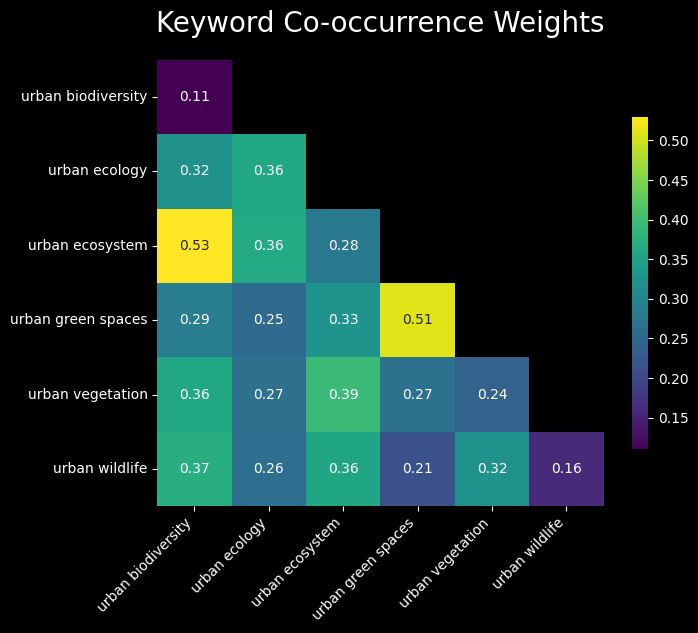

In [172]:
num_keywords = len(cooc_matrix)
cell_size = 1.2

plt.figure(figsize=(num_keywords * cell_size, num_keywords * cell_size))

mask = np.triu(np.ones_like(cooc_matrix, dtype=bool), k=1)

sns.heatmap(cooc_matrix, 
            mask=mask,
            cmap="viridis",
            annot=True,
            fmt=".2f",
            square=True, 
            cbar_kws={"shrink": 0.6})

plt.title("Keyword Co-occurrence Weights", fontdict={'fontsize':20}, pad=20)
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
#Pearson Correlation

# Geographical Data Analysis

In this next step, I'll obtain geographical data to draw a choropleth map with the publication data.

In [ ]:

def convert_alpha2_to_alpha3(alpha2_code):
    """Convert ISO 3166-1 alpha-2 code to alpha-3 code using pycountry"""
    try:
        return pycountry.countries.get(alpha_2=alpha2_code.upper()).alpha_3
    except:
        return None

def get_country_name(alpha2_code):
    """Get country name from ISO 3166-1 alpha-2 code using pycountry"""
    try:
        return pycountry.countries.get(alpha_2=alpha2_code.upper()).name
    except:
        return None

✅ pycountry library loaded successfully
📋 Available conversions:
  - convert_alpha2_to_alpha3(): Convert 2-letter to 3-letter ISO codes
  - get_country_name(): Get full country name from 2-letter code


In [ ]:
# Analyze first author country distribution with proper ISO code conversion
with sqlite3.connect(PAPERS_DB_PATH) as conn:
    df_countries_raw = pd.read_sql_query("""
    SELECT 
        firstAuthorCountryIso as alpha2_code,
        COUNT(*) as paper_count
    FROM papers
    WHERE firstAuthorCountryIso IS NOT NULL
    GROUP BY firstAuthorCountryIso
    ORDER BY paper_count DESC
    """, conn)

# Add proper ISO conversions and country names
df_countries = df_countries_raw.copy()
df_countries['alpha3_code'] = df_countries['alpha2_code'].apply(convert_alpha2_to_alpha3)
df_countries['country_name'] = df_countries['alpha2_code'].apply(get_country_name)

# Handle any unmapped codes
unmapped = df_countries[df_countries['alpha3_code'].isna()]
if not unmapped.empty:
    print('⚠️ Found unmapped country codes:')
    for _, row in unmapped.iterrows():
        print(f'{row["alpha2_code"]}: {row["paper_count"]} papers')

# Clean data and show results
df_countries_clean = df_countries.dropna(subset=['alpha3_code', 'country_name'])

print(f'\n📊 Country Distribution Analysis:')
print(f'Total countries: {len(df_countries_clean)}')
print(f'Total papers with country data: {df_countries_clean["paper_count"].sum():,}')

df_countries.head(20)

⚠️ Found unmapped country codes:
  XK: 3 papers

📊 Country Distribution Analysis:
Total countries: 171
Total papers with country data: 28,776


,alpha2_code,paper_count,alpha3_code,country_name
0,US,6780,USA,United States
1,GB,3096,GBR,United Kingdom
2,IT,1548,ITA,Italy
3,AU,1332,AUS,Australia
4,DE,1328,DEU,Germany
5,IN,1189,IND,India
6,CN,1066,CHN,China
7,FR,907,FRA,France
8,ES,802,ESP,Spain
9,CA,798,CAN,Canada


In [ ]:
# Create world map visualization using proper ISO 3-letter codes
fig = px.choropleth(
    df_countries_clean, 
    locations='alpha3_code',
    color='paper_count',
    hover_name='country_name',
    hover_data={
        'alpha3_code': True, 
        'paper_count': ':,',
        'country_name': False
    },
    color_continuous_scale='Viridis',
    title='Global Distribution of Urban Ecology Research Papers by First Author Country',
    labels={
        'paper_count': 'Number of Papers',
        'alpha3_code': 'ISO Alpha-3'
    }
)

fig.update_layout(
    width=1200,
    height=700,
    title_font_size=16,
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='natural earth'
    )
)

fig.show()

print('=' * 80)

fig_treemap = px.treemap(
    df_countries_clean.head(20),
    names='country_name',
    values='paper_count',
    parents=[''] * 20, 
    title='Top 20 Countries by Urban Ecology Research Output',
    labels={'paper_count': 'Number of Papers', 'country_name': 'Country'},
    color='paper_count',
    color_continuous_scale='Viridis',
    hover_data={
        'alpha2_code': True,
        'alpha3_code': True,
        'paper_count': ':,',
    }
)

# Threshold calculation to avoid unreadable text
max_val = df_countries_clean.head(20)['paper_count'].max()
min_val = df_countries_clean.head(20)['paper_count'].min()
threshold = min_val + (max_val - min_val) * 0.7

text_colors = ['black' if val > threshold else 'white' for val in df_countries_clean.head(20)['paper_count']]

fig_treemap.update_traces(
    textinfo='label+value',
    textfont_size=12,
    textfont_color=text_colors,
    hovertemplate='<b>%{label}</b><br>' +
                  'Papers: %{value:,}<br>' +
                  'ISO-3: %{customdata[1]}<br>' +
                  '<extra></extra>'
)

fig_treemap.update_layout(
    height=700,
    width=1200,
    template='plotly_dark',
    font=dict(size=14),
    title_font_size=18,
    margin=dict(t=50, l=25, r=25, b=25)
)

fig_treemap.show()